# Hierarchical Approaches

When facing routing problems at larger scales, such as those involving entire continents or graphs with millions of nodes, it is simply implausible to use basic approaches like Dijkstra or DFS. Instead, routing algorithms "prune" the search space in order to simplify the routing problem. Additionally, routing services may choose to precompute certain routes and cache them on servers, so that response times to user queries are reasonable.

Hierarchical search algorithms prune the search space by generating admissible heuristics that abstract the search space. Read more about the general approach of hierarchical methods at [Faster Optimal and Suboptimal Hierarchical Search](https://www.aaai.org/ocs/index.php/SOCS/SOCS11/paper/viewFile/4035/4363).

In this section, we'll give a brief overview of two hierarchical approaches that aim to solve the shortest path problem, and show how their heuristics are computed. There will also be a `python` implementation of the Contraction Hierarchies example.

---

## Highway Hierarchies

In this algorithm, the hierarchy "level" of each road/arc in the graph is calculated. This distinguishes the type of road segment (i.e. residential, national roads, highways). This is further supplemented by relevant data such as maximum designated driving speed, as well as number of turns in the road. After the heuristics are generated for the graph, the data is passed through a modified search function (bi-directional Dijkstra, A*, etc) that considers the distance to the destination and the potential expansion node class. 

For example, the algorithm will generally consider highways as viable expansion nodes when it is still relatively further away from the target, and then will start to include national roads, and finally residential streets as it nears the destination. 

While this approach "makes sense", there are some disadvantages. First, the algorithm largely overlooks what kind of roads humans "prefer" to drive on. That is to say, which a highway might make sense for a given route, the user may "prefer" to take local roads (i.e. driving to a friend's house who lives nearby). Secondly, highway hierarchies do not take into account factors such as traffic, which fluctuates often and adds significant cost to an "optimal" route.

You can learn more about contraction hierarchies [here](https://link.springer.com/chapter/10.1007/11561071_51).

---

## Contraction Hierarchies
While the highway hierarchies algorithm may be useful for speeding up shortest path searches, it only considers three levels of road hierarchies. On the other hand, the contraction hierarchies algorithm introduced by [Contraction Hierarchies: Faster and Simpler Hierarchical Routing in Road Networks](https://link.springer.com/chapter/10.1007/978-3-540-68552-4_24) has the same number of hierarchies as nodes in the graph, which is beneficial as increased number of hierarchies results in more pruning of the search space.

### Contraction
Taking any node $V$ from a graph $G$, remove $V$ as well as any connected edges. <br>
Add any number of edges to $G$ such that the shortest distance for any pair of neighbouring nodes remains the same, even after $V$ has been removed. Below is an example:<br>
![](../../images/uncontract.png)

Suppose we are contracting **Node 1**. By removing the node, we have now changed the shortest path for 0&rarr;2, 0&rarr;3, and 2&rarr;3. We can restore it by creating new edges. After the creation of new edges, we then reinsert any removed nodes and edges. We then update that node with its hierarchy level (which is just the order of contraction, from $1 to n$). See the below updated graph:<br><br>
![](../../images/contract.png)

This process is then repeated for all the other nodes. In our example, no other nodes need to be contracted, as removing any one of the remaining nodes does not affect the rest of the graph in terms of shortest path. This process will form **shortcuts**, which allow us to search the graph much faster, as we can ignore certain nodes that have been "pruned".

### Contraction Order
Any order for node contraction will result in a successful algorithm, however some contraction ordering systems minimizes the number of new edges added to the graph, and thus the overall running time.

To utilize this, we can employ the idea of **edge difference (ED)**. The ED of a node is $S-E$, where $S$ is the number of new edges added if that node were to be contracted, and $E$ is the number of edges that would be deleted. Minimizing ED is equivalent to minimizing the number of new edges added to the graph, and thus improves processing time.

---

## Example #1: Bi-directional Dijkstra with contraction

After contracting a graph, we can run a bi-directional Dijkstra to compute all the shortest paths in the graph. Following this, any queries for the shortest path between any two nodes in the graph can be solved using a cached result.

There are some restrictions for our modified Dijkstra's:

1. The forward expansion only considers arcs $u,v$, where $level(u) > level(v)$. This forms the **upward graph**, where only nodes with a higher contraction order can be relaxed.
2. The backward expansion only considers arcs $u,v$, where $level(u) < level(v)$. This forms the **downward graph**, where only nodes with a lower contraction order can be relaxed.

These restrictions help "prune" the search space and speed up the processing.

At the end, multiple paths are returned from source to destination, of which the shortest is selected to be the solution.

Let's try this with the sample graph below:

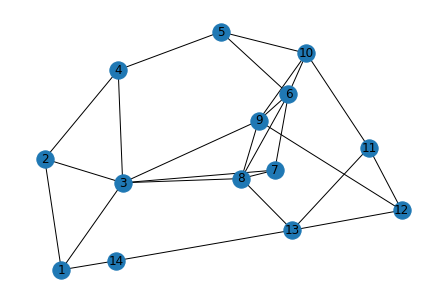

In [1]:
import networkx
import random
import math

G = networkx.Graph()

# Computing each contraction level requires a new graph, which is costly in terms of memory.
# To avoid this, we use a flag on every node to show its contraction state.

# Add 14 nodes
for i in range(1,15):
    G.add_node(i, contracted=False)

# Define the edges
edges = [
    (1,2,{'weight':1}),
    (1,3,{'weight':4}),
    (2,3,{'weight':5}),
    (2,4,{'weight':2}),
    (3,4,{'weight':2}),
    (3,7,{'weight':2}),
    (3,8,{'weight':1}),
    (3,9,{'weight':1}),
    (4,5,{'weight':5}),
    (5,10,{'weight':7}),
    (6,7,{'weight':4}),
    (6,8,{'weight':3}),
    (6,10,{'weight':3}),
    (6,5,{'weight':3}),
    (6,9,{'weight':1}),
    (7,8,{'weight':6}),
    (8,9,{'weight':3}),
    (8,13,{'weight':5}),
    (9,12,{'weight':1}),
    (9,10,{'weight':3}),
    (10,11,{'weight':4}),
    (11,12,{'weight':3}),
    (11,13,{'weight':4}),
    (12,13,{'weight':2}),
    (14,1,{'weight':3}),
    (14,13,{'weight':2})
]
# Add the edges to the graph and visualize it.
G.add_edges_from([*edges])
networkx.draw(G,with_labels=True)

:::{note}
For this implementation we will be using two helper functions from `smart_mobility_utilities.contraction`.

The first is `dijkstra_with_contraction`, which simple runs a Dijkstra search on a graph, with the condition that the expansion nodes cannot be already contracted.

The second is `calculate_edge_difference`, which calculates the ED for every node in a given graph.

See the API docs for `smart_mobility_utilities.contraction` for more details.
:::

We will first need to obtain the ED for the input graph:

In [2]:
from smart_mobility_utilities.contraction import *
shortest_paths = dict()
for i in G.nodes():
    shortest_paths[i] = dict()
    for j in G.nodes():
        shortest_paths[i][j] = dijkstra_with_contraction(G, i, j)

edge_difference = calculate_edge_difference(G,shortest_paths)
edge_difference.sort(key=lambda pair: pair[1])

edge_difference

[(8, -5),
 (10, -4),
 (5, -3),
 (7, -3),
 (11, -3),
 (14, 0),
 (2, 2),
 (1, 3),
 (6, 4),
 (13, 5),
 (4, 7),
 (12, 18),
 (3, 26),
 (9, 33)]

While this is a good start to optimizing the node contraction order, it is by no means perfect. Notice that the ED values calculated above assume the node is the only node removed from the graph. Because we are successively removing every node in the graph, the ED list will potentially become inaccurate after even the first contraction.

Recall however that any arbitrary contraction order results in a successful algorithm. While there are ED heuristics that are able to update the ED list after each contraction, each of them come with their own costs and benefits.

For the purposes of this example, our ED list will be sufficient.

In [3]:
# to keep track of the edges added after the algorithm finishes
edges_before = [*G.edges()]

current_graph = [*G.nodes()]

for node_ED in edge_difference:
    node = node_ED[0]
    
    # now we will contract the given node through all iterations
    networkx.set_node_attributes(G, {node: True}, 'contracted')
    
    new_graph = current_graph
    new_graph.remove(node)
    current_shortest_paths = dict()
    for source in new_graph:
            current_shortest_paths[source] = dict()
            for destination in new_graph:
                current_shortest_paths[source][destination] = dijkstra_with_contraction(G,source, destination)
                
    for source in current_shortest_paths:
        SP_contracted = current_shortest_paths[source]
        SP_original = shortest_paths[source]
        for destination in SP_contracted:
            if source == destination: continue
            if SP_contracted[destination] != SP_original[destination]:
                print("Added edge between ", source, destination," after contracting", node)
                
                G.add_edge(source, destination, weight=SP_original[destination])
                
    current_graph = new_graph

# new edges after adding additional arcs
edges_after = [*G.edges()]
print("# edges before", len(edges_before))
print("# edges after", len(edges_after))

Added edge between  1 13  after contracting 14
Added edge between  2 13  after contracting 14
Added edge between  13 1  after contracting 14
Added edge between  13 2  after contracting 14
Added edge between  1 4  after contracting 2
Added edge between  4 1  after contracting 2
# edges before 26
# edges after 29


While it may seem like edges are being added twice, this is a simple graph, so adding an edge `(b,a)` when there is already an edge `(a,b)` has no effect.

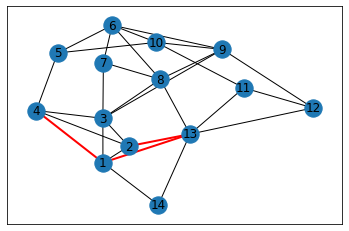

In [4]:
# Visualize the newly created "shortcute" on the graph

added_edges = list(set(edges_after) - set(edges_before))

# let's color these edges and draw the graph again
colors = ['r' if edge in added_edges else 'k' for edge in G.edges()]
widths = [2 if edge in added_edges else 1 for edge in G.edges()]
networkx.draw_networkx(G,with_labels=True,width=widths, edge_color=colors)

In [5]:
# Reformat ED list to hierarchy for search purposes
hierarchical_order = dict()
for order, node in enumerate(edge_difference):
    hierarchical_order[node[0]] = order
    
hierarchical_order

{8: 0,
 10: 1,
 5: 2,
 7: 3,
 11: 4,
 14: 5,
 2: 6,
 1: 7,
 6: 8,
 13: 9,
 4: 10,
 12: 11,
 3: 12,
 9: 13}

Let's now find the shortest path from $8$ to $12$, using Dijkstra's with contraction hierarchy.

In [6]:
source = 8
destination = 12

In [7]:
# Generating the upward graph

# initializing 
SP_s = dict()
parent_s = dict()
unrelaxed_s = list()
for node in G.nodes():
    SP_s[node] = math.inf
    parent_s[node] = None
    unrelaxed_s.append(node)
SP_s[source] = 0

# dijkstra
while unrelaxed_s:
    node = min(unrelaxed_s, key = lambda node : SP_s[node])
    unrelaxed_s.remove(node)
    if SP_s[node] == math.inf: break
    for child in G[node]:
        # skip unqualified edges
        if hierarchical_order[child] < hierarchical_order[node]: continue
        distance = SP_s[node] + G[node][child]['weight']
        if distance < SP_s[child]:
            SP_s[child] = distance
            parent_s[child] = node

In [8]:
# Generating the downward graph

# initializing 
SP_t = dict()
parent_t = dict()
unrelaxed_t = list()
for node in G.nodes():
    SP_t[node] = math.inf
    parent_t[node] = None
    unrelaxed_t.append(node)
SP_t[destination] = 0

# dijkstra
while unrelaxed_t:
    node = min(unrelaxed_t, key = lambda node : SP_t[node])
    unrelaxed_t.remove(node)
    if SP_t[node] == math.inf: break
    for child in G[node]:
        # skip unqualified edges
        if hierarchical_order[child] < hierarchical_order[node]: continue
        distance = SP_t[node] + G[node][child]['weight']
        if distance < SP_t[child]:
            SP_t[child] = distance
            parent_t[child] = node


With these, we now merge the common settled nodes from `SP_d` and `SP_s`, and find the minimum sum of values, This is our shortest path: the collision between the forward and backward expansions.

In [9]:
minimum = math.inf
merge_node = None
for i in SP_s:
    if SP_t[i] == math.inf: continue
    if SP_t[i] + SP_s[i] < minimum:
        minimum = SP_t[i] + SP_s[i]
        merge_node = i

print("Minimum:",minimum)
print("Merge node:",merge_node)

Minimum: 3
Merge node: 9


Let's compare this to `networkx`'s built in solver:

In [10]:
from networkx.algorithms.shortest_paths.weighted import single_source_dijkstra
single_source_dijkstra(G,source, destination)

(3, [8, 3, 9, 12])

### Pruning

We can actually check to see how many nodes were "pruned" from our graph, using the upward and downward graphs generated earlier.

In [11]:
unvisited = 0
for s_node, s_dist in SP_s.items():
    for t_node, t_dist in SP_t.items():
        if s_node == t_node and s_dist == t_dist == math.inf:
            unvisited += 1
print(f"""Skipped {unvisited} nodes from a graph with {len(G)} total nodes,
resulting in pruning {unvisited/len(G)*100}% of the nodes in our search space.""")

Skipped 7 nodes from a graph with 14 total nodes,
resulting in pruning 50.0% of the nodes in our search space.


---

## Example #2: Equestrian Statue to Bahen Centre using Contraction Hierarchy

We can also use the same method to calculate the shortest path between our statue and lecture hall.

Contraction hierarchies typically require incredibly powerful processing resources to run, especially when dealing with larger scales. Our ED function runs in $O(n^2)$ time, so for a graph of size 1,189 (our University of Toronto map), this requires 1,413,721 runs of `dijkstra_with_contraction`, which itself takes ~0.1 s per call. This would mean just calculating the ED would take 39 hours!

For this example, we've leveraged the use of some HPC (High-performance computing) resources to be able to generate the ED list in a more reasonable amount of time.

@TODO